In [1]:
import os

def rename_frames(dir_name, class_name):
    imgs = os.listdir(dir_name)
    for i in range(len(imgs)):
        os.rename(dir_name+imgs[i], dir_name+class_name+"_"+str(i)+".jpg")


rename_frames("non_falling_dataset/", class_name="non_fall")
rename_frames("falling_dataset/", class_name="fall")

In [8]:
fall_dataset = len(os.listdir("falling_dataset/"))
non_fall_dataset = len(os.listdir("non_falling_dataset/"))
fall_dataset, non_fall_dataset

(2403, 2879)

In [2]:
import random

random_test_fall = random.sample(os.listdir("falling_dataset/"), 600)
random_test_non_fall = random.sample(os.listdir("non_falling_dataset/"), 600)

In [16]:
from shutil import copyfile

test_fall_dst = "Dataset/Validation/falling/"
test_non_fall_dst = "Dataset/Validation/non_falling/"

train_fall_dst = "Dataset/Training/falling/"
train_non_fall_dst = "Dataset/Training/non_falling/"


fall_dataset = os.listdir("falling_dataset/")

for i in range(len(fall_dataset)):
    if fall_dataset[i] in random_test_fall:
        copyfile("falling_dataset/"+fall_dataset[i], test_fall_dst+fall_dataset[i])
    else:
        copyfile("falling_dataset/"+fall_dataset[i], train_fall_dst+fall_dataset[i])


        
non_fall_dataset = os.listdir("non_falling_dataset/")

for i in range(len(non_fall_dataset)):
    if non_fall_dataset[i] in random_test_non_fall:
        copyfile("non_falling_dataset/"+non_fall_dataset[i], test_non_fall_dst+non_fall_dataset[i])
    else:
        copyfile("non_falling_dataset/"+non_fall_dataset[i], train_non_fall_dst+non_fall_dataset[i])

In [4]:
base_dir = 'Dataset/'

train_dir = os.path.join(base_dir, 'Training')
validation_dir = os.path.join(base_dir, 'Validation')

# Directory with our training fall/nonfall pictures
train_fall_dir = os.path.join(train_dir, 'falling')
train_non_fall_dir = os.path.join(train_dir, 'non_falling')

# Directory with our validation fall/nonfall pictures
validation_fall_dir = os.path.join(validation_dir, 'falling')
validation_non_fall_dir = os.path.join(validation_dir, 'non_falling')

In [5]:
train_fall_dir, train_non_fall_dir, validation_fall_dir, validation_non_fall_dir

('Dataset/Training/falling',
 'Dataset/Training/non_falling',
 'Dataset/Validation/falling',
 'Dataset/Validation/non_falling')

In [6]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images

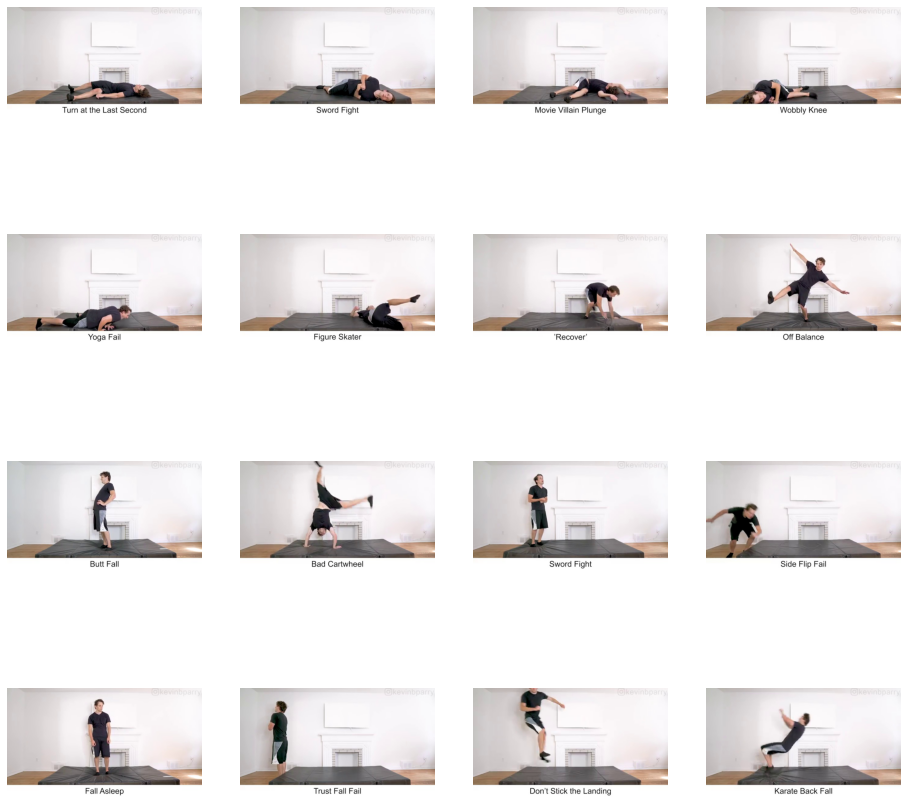

In [7]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_fall_pix = [os.path.join(train_fall_dir, fname) 
                for fname in os.listdir(train_fall_dir)[ pic_index-8:pic_index] 
               ]

next_non_fall_pix = [os.path.join(train_non_fall_dir, fname) 
                for fname in os.listdir(train_non_fall_dir)[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_fall_pix+next_non_fall_pix):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

In [8]:
import tensorflow as tf

In [9]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'), 
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

In [11]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator( rescale = 1.0/255. )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))


Found 4082 images belonging to 2 classes.
Found 1200 images belonging to 2 classes.


In [13]:
history = model.fit(train_generator,
                              validation_data=validation_generator,
                              steps_per_epoch=100,
                              epochs=15,
                              validation_steps=50,
                              verbose=2)

Epoch 1/15
100/100 - 40s - loss: 0.5339 - accuracy: 0.8592 - val_loss: 0.1755 - val_accuracy: 0.9300
Epoch 2/15
100/100 - 43s - loss: 0.2958 - accuracy: 0.9330 - val_loss: 0.1619 - val_accuracy: 0.9510
Epoch 3/15
100/100 - 41s - loss: 0.1259 - accuracy: 0.9495 - val_loss: 0.1369 - val_accuracy: 0.9610
Epoch 4/15
100/100 - 35s - loss: 0.2254 - accuracy: 0.9627 - val_loss: 0.1302 - val_accuracy: 0.9680
Epoch 5/15
100/100 - 38s - loss: 0.0959 - accuracy: 0.9690 - val_loss: 0.1276 - val_accuracy: 0.9630
Epoch 6/15
100/100 - 39s - loss: 0.0934 - accuracy: 0.9647 - val_loss: 0.1554 - val_accuracy: 0.9680
Epoch 7/15
100/100 - 34s - loss: 0.0650 - accuracy: 0.9733 - val_loss: 0.1574 - val_accuracy: 0.9690
Epoch 8/15
100/100 - 34s - loss: 0.0728 - accuracy: 0.9790 - val_loss: 0.2108 - val_accuracy: 0.9700
Epoch 9/15
100/100 - 34s - loss: 0.0850 - accuracy: 0.9750 - val_loss: 0.1451 - val_accuracy: 0.9810
Epoch 10/15
100/100 - 33s - loss: 0.0598 - accuracy: 0.9805 - val_loss: 0.1841 - val_accura

Text(0.5, 1.0, 'Training and validation loss')

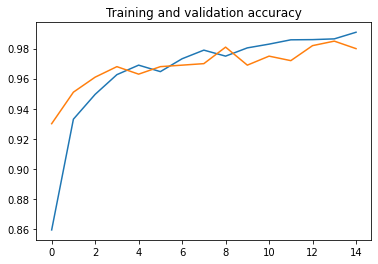

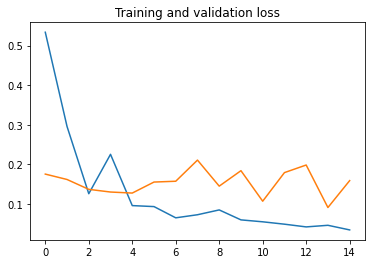

In [14]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )

In [15]:
from keras.models import model_from_json

# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [16]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

Loaded model from disk


In [18]:
score = loaded_model.evaluate_generator(validation_generator)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

accuracy: 98.17%


In [19]:
from keras.preprocessing import image
import numpy as np

In [20]:
for i in os.listdir("Dataset/Validation/falling/")[0:1]:
    img=image.load_img("Dataset/Validation/falling/"+i, target_size=(150, 150))

    x=image.img_to_array(img)
    x=np.expand_dims(x, axis=0)
    images = np.vstack([x])

    classes = loaded_model.predict(images, batch_size=10)
    if int(classes[0][0]) == 0:
        print("fall")
    else:
        print("non_fall")

fall


In [51]:
150*150

22500

In [43]:
model.save("CNN_model")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: CNN_model/assets


In [44]:
from tensorflow import keras
loaded_model = keras.models.load_model('CNN_model/')

In [46]:
for i in os.listdir("Dataset/Validation/non_falling/"):
    img=image.load_img("Dataset/Validation/non_falling/"+i, target_size=(150, 150))

    x=image.img_to_array(img)
    x=np.expand_dims(x, axis=0)
    images = np.vstack([x])

    classes = loaded_model.predict(images, batch_size=10)
    if int(classes[0][0]) == 0:
        print("fall")
    else:
        print("non_fall")

non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
non_fall
